#### Calculate the ym_per_pix and xm_per_pix

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

In [14]:
# Read in the saved camera calibration settings
dist_pickle = pickle.load(open( "./calibration_pickle.p", "rb"))
mtx= dist_pickle['mtx']
dist = dist_pickle['dist']


In [15]:
# Plot the result
def plotImage(image, image_cmap=None,  save_filename=None):
    plt.imshow(image,cmap=image_cmap)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()

def plot3images(image1, image2, imge3, title1, title2, title3, 
                image1cmap=None, image2cmap='gray',image3cmap='gray', save_filename=None):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=image1cmap)
    ax1.set_title(title1, fontsize= 20)
    ax2.imshow(image2, cmap=image2cmap)
    ax2.set_title(title2, fontsize= 20)
    ax3.imshow(image3, cmap=image1cmap)
    ax3.set_title(title3, fontsize= 20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()

def plot2images(image1, image2, title1, title2, image1cmap=None, image2cmap='gray', save_filename=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=image1cmap)
    ax1.set_title(title1, fontsize= 30)
    ax2.imshow(image2, cmap=image2cmap)
    ax2.set_title(title2, fontsize= 30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()
    


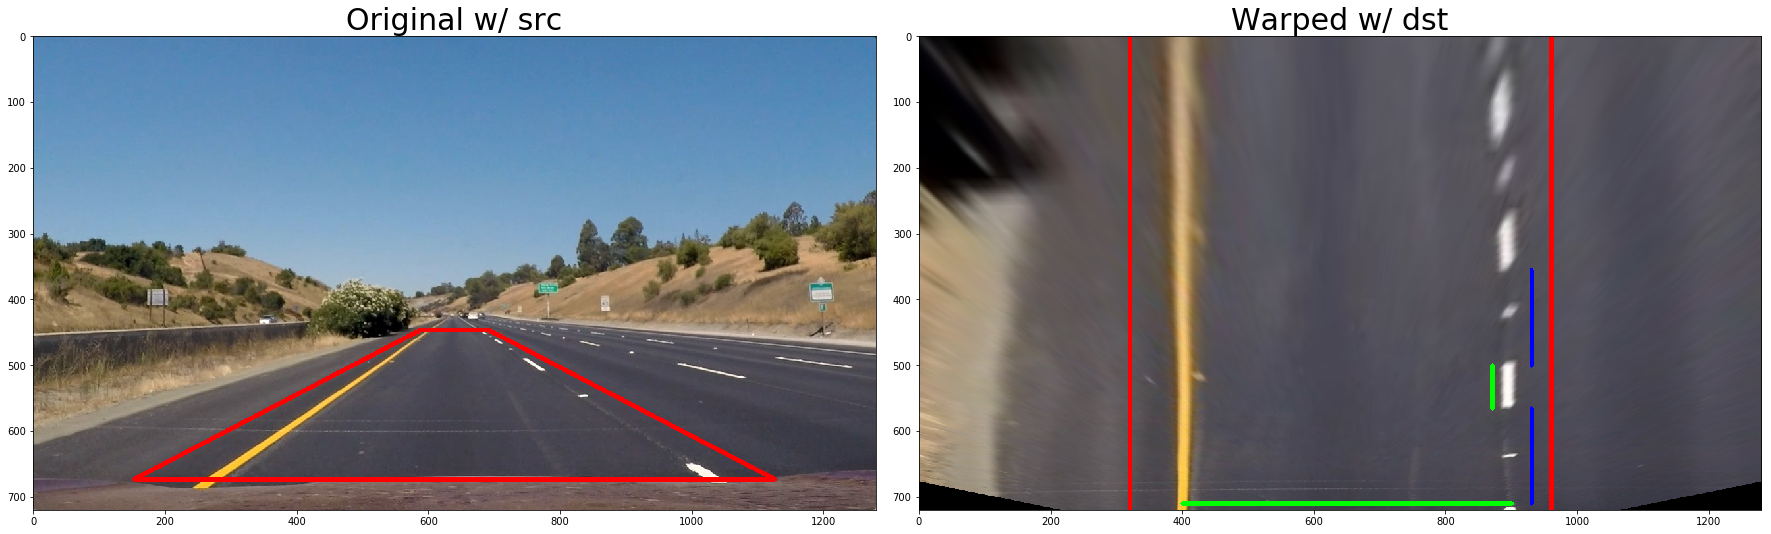

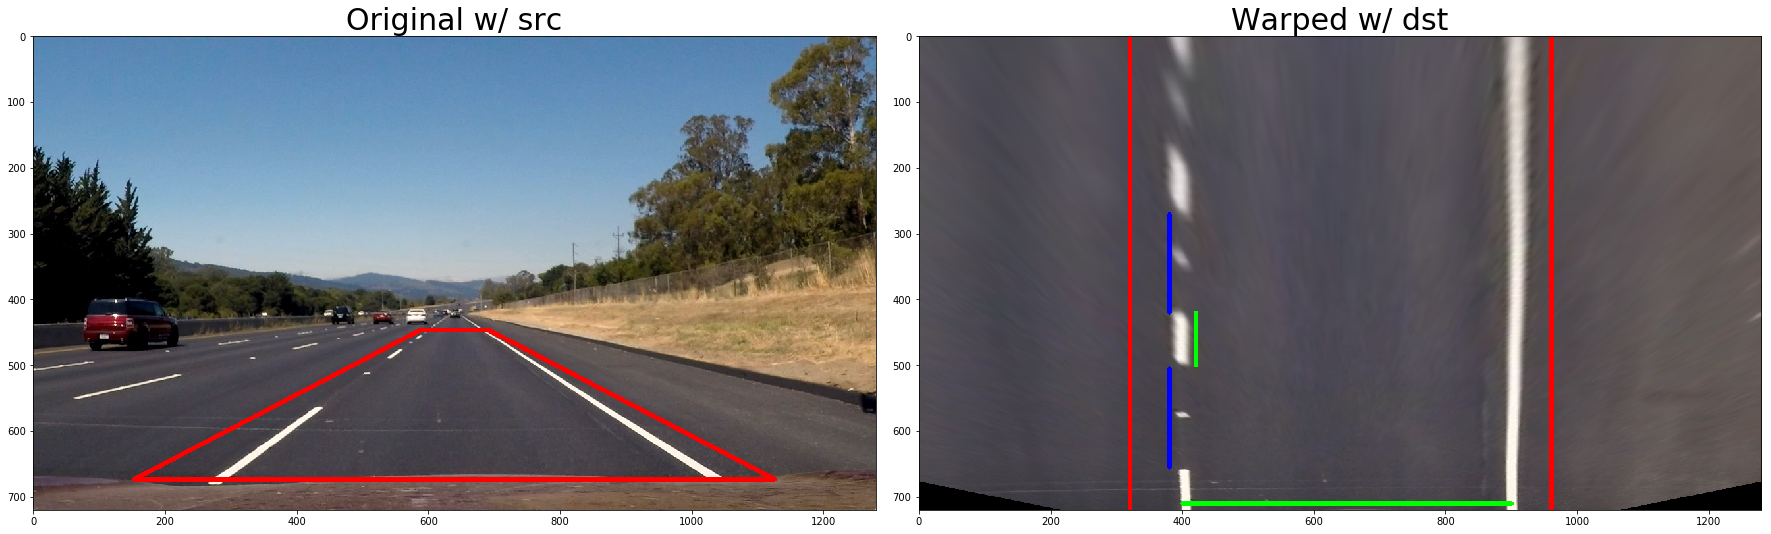

In [59]:
def calc_src_dst(img):
    img_size = (img.shape[1], img.shape[0])
    # 76 08, 62 935, 25
    bottom_width = .76       # percent of bottom trapizoid height
    middle_width = .08       # percent of middle trapizoid height
    height_percentage = .62  # percent of the trapezoid height
    bottom_trim = .935        # percent from top to bottom to avoid car hood
    
    src = np.float32([[img.shape[1]*(.5-middle_width/2), img.shape[0]*height_percentage],
                      [img.shape[1]*(.5+middle_width/2), img.shape[0]*height_percentage],
                      [img.shape[1]*(.5+bottom_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bottom_width/2), img.shape[0]*bottom_trim]
                     ])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, 0], 
                  [img_size[0]-offset, img_size[1]],
                  [offset, img_size[1]]])
     
    #print(src)
    #print(dst)
    
    return (src, dst)
    
def perspective_transform (img):
    
    img_size = (img.shape[1], img.shape[0])
    
    (src, dst) = calc_src_dst(img)
    
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)

    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
       
    return (Minv, warped)

def warp_image(img):
    
    # undistort the image
    undistort = np.copy(img)
    undistort = cv2.undistort(undistort, mtx, dist, None, mtx)
    print(img.shape)
    
    # Preprocess Images
    preprocessedImage = preprocess_image(undistort)
    print(preprocessedImage.shape)
    
    Minv, warped = perspective_transform (preprocessedImage)
    print(warped.shape)
    
    return Minv, warped
    

#use the test images
images = glob.glob('./test_images/straight_lines*.jpg')
#images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_frame_images/frame_*.jpg')
#images = glob.glob('./test_frame_images/frame_1*.jpg')
#images = glob.glob('./test_frame_images/frame_20.jpg')
for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
    
    (src, dst) = calc_src_dst(img)
    src_reshape = np.array(src, np.int32).reshape((-1,1,2))
    src_image = np.copy(img)
    cv2.polylines(src_image, [src_reshape], True, (255,0,0), 5)

    # undistort the image
    undistort = np.copy(img)
    undistort = cv2.undistort(undistort, mtx, dist, None, mtx)
    
    # Preprocess Images
    #preprocessedImage = preprocess_image(undistort)
    Minv, warped = perspective_transform (undistort)

    dst_image = np.copy(warped)
    dst_int = np.array(dst, np.int32)
    pt0 = tuple(dst_int[0])
    pt1= tuple(dst_int[1])
    pt2 = tuple(dst_int[2])
    pt3 = tuple(dst_int[3])
    
    cv2.line(dst_image, pt0, pt3, (255,0,0), 5)
    cv2.line(dst_image, pt1, pt2, (255,0,0), 5)
    cv2.line(dst_image, (400,710),(900,710), (0,255,0), 5)
    
    if (idx == 0):
        cv2.line(dst_image, (870,500),(870,565), (0,255,0), 5)
        cv2.line(dst_image, (930,355),(930,500), (0,0,255), 5)
        cv2.line(dst_image, (930,565),(930,710), (0,0,255), 5)
    else:
        cv2.line(dst_image, (420,420),(420,500), (0,255,0), 5)
        cv2.line(dst_image, (380,270),(380,420), (0,0,255), 5)
        cv2.line(dst_image, (380,505),(380,655), (0,0,255), 5)
        
    
    imageName = 'src_dst'+str(idx)+'.jpg'
    plot2images(image1=src_image, image2=dst_image, title1='Original w/ src', title2='Warped w/ dst',  save_filename='./output_images/'+ imageName)


In [8]:
# Read in the saved camera calibration settings
dist_pickle = pickle.load(open( "./calibration_pickle.p", "rb"))
mtx= dist_pickle['mtx']
dist = dist_pickle['dist']


def create_birds_eye(img, visualize = False):
    img_size = (img.shape[1], img.shape[0])
    
    # 76 08, 62 935, 25
    bottom_width = .76       # percent of bottom trapizoid height
    middle_width = .08       # percent of middle trapizoid height
    height_percentage = .62  # percent of the trapezoid height
    bottom_trim = .935        # percent from top to bottom to avoid car hood
    
    src = np.float32([[img.shape[1]*(.5-middle_width/2), img.shape[0]*height_percentage],
                      [img.shape[1]*(.5+middle_width/2), img.shape[0]*height_percentage],
                      [img.shape[1]*(.5+bottom_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bottom_width/2), img.shape[0]*bottom_trim]
                     ])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, 0], 
                  [img_size[0]-offset, img_size[1]],
                  [offset, img_size[1]]])

    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)

    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if (visualize):
        dst_image = np.copy(warped)
        src_int = np.array(src, np.int32)
        dst_int = np.array(dst, np.int32)
        print ('src=', src_int)
        print ('dst=', dst_int)
        pt0 = tuple(dst_int[0])
        pt1= tuple(dst_int[1])
        pt2 = tuple(dst_int[2])
        pt3 = tuple(dst_int[3])

        cv2.line(dst_image, pt0, pt3, (255,0,0), 5)
        cv2.line(dst_image, pt1, pt2, (255,0,0), 5)

        imageName = 'src_dst'+str(idx)+'.jpg'
        #imageName = 'src_dst_curved'+'.jpg'
        plot2images(image1=img, image2=dst_image, title1='Original w/ src', title2='Warped w/ dst',  save_filename=None)
    
    return Minv, warped
    
images = glob.glob('./test_images/straight_lines*.jpg')
#mages = glob.glob('./test_frame_images/frame_05.jpg')
for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)

    Minv, warped = create_birds_eye(undistort, visualize = True)
    
       

NameError: name 'pickle' is not defined

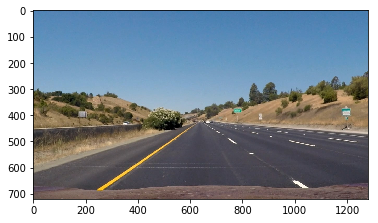

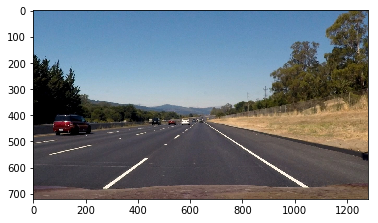

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

### Define conversions in x and y from pixels space to meters
images = glob.glob('./test_images/straight_lines*.jpg')
for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
    
    #undistort = cv2.undistort(img, mtx, dist, None, mtx)

    #Minv, warped = create_birds_eye(undistort, visualize = True)
    plt.imshow(img)
    plt.show()
    